In [1]:
from services import download, unzip
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
import matplotlib.pyplot as plt

/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
LTA_COE_BIDDING_RESULT = "https://datamall.lta.gov.sg/content/dam/datamall/datasets/Facts_Figures/Vehicle%20Registration/COE%20Bidding%20Results.zip"

# Download and unzip the dataset
zip_file_path = download(LTA_COE_BIDDING_RESULT, "/data")
csv_file_pattern = "*-coe_results.csv"
data = unzip(zip_file_path, csv_file_pattern)

# Convert 'month' to datetime and filter data for the specified years
data['month'] = pd.to_datetime(data['month'])

# Clean and convert bids columns to integer
data['bids_received'] = data['bids_received'].str.replace(',', '').astype(int)

# Filter data for Category A
category_a_data = data[data['vehicle_class'] == 'Category A']
print(category_a_data)
# Aggregate data to monthly level
monthly_data = category_a_data.groupby(category_a_data['month'].dt.to_period('M')).agg({
    'premium': 'mean',
    'bids_success': 'mean',
    'bids_received': 'mean'
}).reset_index()
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

          month  bidding_no vehicle_class  quota  bids_success  bids_received  \
0    2010-01-01           1    Category A   1152          1145           1342   
5    2010-01-01           2    Category A   1151          1149           1673   
10   2010-02-01           1    Category A   1154          1153           1326   
15   2010-02-01           2    Category A   1148          1148           1493   
20   2010-03-01           1    Category A   1148          1141           1758   
...         ...         ...           ...    ...           ...            ...   
1670 2024-03-01           1    Category A    963           923           1866   
1675 2024-03-01           2    Category A    936           935           1922   
1680 2024-04-01           1    Category A    975           970           1922   
1685 2024-04-01           2    Category A    936           916           1390   
1690 2024-05-01           1    Category A    968           968           1632   

      premium  
0       185

In [3]:
dereg_data = {
    'Date': ['2024-Mar', '2024-Feb', '2024-Jan', '2023-Dec', '2023-Nov', '2023-Oct', '2023-Sep', '2023-Aug', '2023-Jul', '2023-Jun', '2023-May',
             '2023-Apr', '2023-Mar', '2023-Feb', '2023-Jan', '2022-Dec', '2022-Nov', '2022-Oct', '2022-Sep', '2022-Aug', '2022-Jul', '2022-Jun',
             '2022-May', '2022-Apr', '2022-Mar', '2022-Feb', '2022-Jan', '2021-Dec', '2021-Nov', '2021-Oct', '2021-Sep', '2021-Aug', '2021-Jul',
             '2021-Jun', '2021-May', '2021-Apr', '2021-Mar', '2021-Feb', '2021-Jan', '2020-Dec', '2020-Nov', '2020-Oct', '2020-Sep', '2020-Aug',
             '2020-Jul', '2020-Jun', '2020-May', '2020-Apr', '2020-Mar', '2020-Feb', '2020-Jan', '2019-Dec', '2019-Nov', '2019-Oct', '2019-Sep',
             '2019-Aug', '2019-Jul', '2019-Jun', '2019-May', '2019-Apr', '2019-Mar', '2019-Feb', '2019-Jan', '2018-Dec', '2018-Nov', '2018-Oct',
             '2018-Sep', '2018-Aug', '2018-Jul', '2018-Jun', '2018-May', '2018-Apr', '2018-Mar', '2018-Feb', '2018-Jan', '2017-Dec', '2017-Nov',
             '2017-Oct', '2017-Sep', '2017-Aug', '2017-Jul', '2017-Jun', '2017-May', '2017-Apr', '2017-Mar', '2017-Feb', '2017-Jan', '2016-Dec',
             '2016-Nov', '2016-Oct', '2016-Sep', '2016-Aug', '2016-Jul', '2016-Jun', '2016-May', '2016-Apr', '2016-Mar', '2016-Feb', '2016-Jan',
             '2015-Dec', '2015-Nov', '2015-Oct', '2015-Sep', '2015-Aug', '2015-Jul', '2015-Jun', '2015-May', '2015-Apr', '2015-Mar', '2015-Feb',
             '2015-Jan', '2014-Dec', '2014-Nov', '2014-Oct', '2014-Sep', '2014-Aug', '2014-Jul', '2014-Jun', '2014-May', '2014-Apr', '2014-Mar',
             '2014-Feb', '2014-Jan'],
    'Category_A_DeRegistered': [2420, 1672, 1918, 1939, 1654, 1542, 1510, 1485, 1310, 1253, 1735,
                                1461, 1369, 848, 808, 857, 1424, 1028, 1010, 961, 953, 1089, 955, 1128, 1641,
                                1042, 1383, 1097, 1198, 1243, 1039, 1256, 1249, 1864, 1872, 1607, 1918, 1268, 1383,
                                1425, 1506, 1518, 1537, 1750, 1697, 1756, 1184, 1707, 2397, 1778, 2239, 2145, 2143,
                                2192, 2146, 2176, 2450, 2001, 2316, 2724, 3477, 2570, 3438, 3465, 3872, 3656, 3886,
                                4001, 4213, 3823, 3653, 3604, 3310, 2458, 3778, 3440, 3371, 3554, 3495, 3720, 3762,
                                3886, 4074, 3914, 4428, 3588, 4389, 4513, 4463, 4475, 3798, 4027, 4244, 4064, 4493,
                                4575, 5937, 4105, 4497, 4580, 4216, 4496, 3756, 3252, 3798, 3761, 3627, 3618, 4030,
                                2142, 3174, 2263, 2068, 2080, 1875, 1415, 1507, 1291, 1271, 1347, 1330, 1104, 1011],
     'Category_B_DeRegistered': [1246, 1112, 1236, 1045, 1041, 1023, 1039, 1127, 1065, 1128, 1175, 1002, 1120, 711, 699, 742, 990, 779, 906, 906, 888,
                                849, 921, 977, 1363, 947, 1199, 1167, 1165, 1328, 1240, 1336, 1332, 1680, 1798, 1647, 1804, 1198, 1427, 1590, 1582, 1659,
                                1705, 1790, 1762, 1599, 852, 1394, 2279, 2030, 2111, 2270, 2126, 2127, 2103, 2123, 2510, 2262, 2265, 2412, 2891, 2160,
                                2534, 2661, 2688, 2634, 2556, 2749, 2916, 2757, 2873, 2783, 3043, 2238, 3244, 3261, 2939, 3055, 3019, 2945, 2995, 2813,
                                2962, 2585, 3107, 2570, 2916, 2853, 3115, 2875, 2756, 2666, 2652, 2712, 2957, 3011, 3890, 2579, 3060, 2683, 2634, 2529,
                                2308, 1939, 2382, 2362, 2191, 2289, 2416, 1474, 2095, 1719, 1449, 1433, 1312, 1224, 1217, 1127, 1101, 1068, 1308, 926, 927],
    'Category_C_DeRegistered': [949, 556, 502, 414, 372, 486, 519, 553, 607, 478, 451, 318, 1704, 803, 411, 700, 909, 706, 828, 705, 673, 681, 638,
                                916, 1005, 619, 663, 693, 604, 638, 663, 615, 686, 740, 638, 663, 935, 705, 660, 699, 683, 805, 930, 1095, 914, 853, 301,
                                663, 1407, 914, 787, 875, 1030, 1054, 987, 929, 1164, 1020, 1255, 1523, 1906, 937, 1161, 922, 1190, 1460, 1106, 1224, 1311,
                                1219, 1224, 1246, 1296, 659, 960, 865, 1087, 1030, 1007, 1355, 1445, 979, 1079, 1905, 7040, 1648, 1245, 1219, 1128, 944,
                                1502, 1404, 1371, 1234, 1001, 2341, 2218, 1006, 1319, 1484, 1439, 1658, 1860, 2211, 697, 629, 576, 1029, 1796, 761, 834,
                                837, 1082, 1178, 842, 1162, 951, 716, 590, 1267, 1700, 832, 711],
    'Category_D_DeRegistered': [694, 963, 1019, 837, 745, 873, 794, 914, 954, 800, 957, 907, 1457, 995, 941, 924, 915, 797, 807, 839, 834, 954, 783,
                                944, 1351, 1006, 991, 889, 772, 762, 800, 913, 750, 872, 910, 876, 1150, 912, 1009, 1007, 693, 709, 710, 841, 757, 735,
                                368, 582, 1291, 1182, 1278, 1010, 1175, 1258, 1219, 1342, 1447, 1121, 1418, 1437, 1632, 1225, 1649, 1490, 1304, 1530, 1375,
                                1412, 1541, 1607, 1872, 1237, 1188, 907, 1052, 918, 784, 936, 914, 1044, 848, 916, 878, 969, 1023, 710, 846, 687, 761, 742,
                                751, 712, 730, 794, 781, 688, 1008, 804, 707, 757, 657, 774, 691, 646, 735, 738, 757, 763, 759, 613, 693, 553, 592, 631,
                                624, 673, 733, 643, 637, 742, 796, 668, 760],
}

dereg_df = pd.DataFrame(dereg_data)
dereg_df['Date'] = pd.to_datetime(dereg_df['Date'], format='%Y-%b')
dereg_df = dereg_df.rename(columns={'Date': 'ds', 'Category_A_DeRegistered': 'deregistered_vehicles'})

In [4]:
# Merge the deregistration data with the aggregated monthly COE data
merged_data = pd.merge(monthly_data, dereg_df, left_on='month', right_on='ds', how='inner')

In [5]:
# Prepare the data for Prophet
df_prophet = merged_data[['month', 'premium', 'bids_success', 'bids_received', 'deregistered_vehicles']].rename(columns={'month': 'ds', 'premium': 'y'})
print(df_prophet)

            ds        y  bids_success  bids_received  deregistered_vehicles
0   2014-01-01  72329.5         362.5          673.5                   1011
1   2014-02-01  74382.5         357.0          709.5                   1104
2   2014-03-01  77800.5         358.0          596.0                   1330
3   2014-04-01  74367.5         358.5          525.0                   1347
4   2014-05-01  62845.5         509.0          836.5                   1271
..         ...      ...           ...            ...                    ...
115 2023-11-01  90345.0         920.0         1228.0                   1654
116 2023-12-01  86510.0         919.0         1199.5                   1939
117 2024-01-01  73299.5         920.5         1532.0                   1918
118 2024-02-01  77900.5         923.0         1920.0                   1672
119 2024-03-01  84244.5         929.0         1894.0                   2420

[120 rows x 5 columns]


In [6]:
# Calculate historical averages for future values
avg_bids_success = df_prophet['bids_success'].mean()
avg_bids_received = df_prophet['bids_received'].mean()
avg_deregistered = df_prophet['deregistered_vehicles'].mean()

In [7]:
# Initialize the model
model = Prophet()

# Add additional regressors
model.add_regressor('bids_success')
model.add_regressor('bids_received')
model.add_regressor('deregistered_vehicles')

# Fit the model
model.fit(df_prophet)

18:46:54 - cmdstanpy - INFO - Chain [1] start processing
18:46:54 - cmdstanpy - INFO - Chain [1] done processing


/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


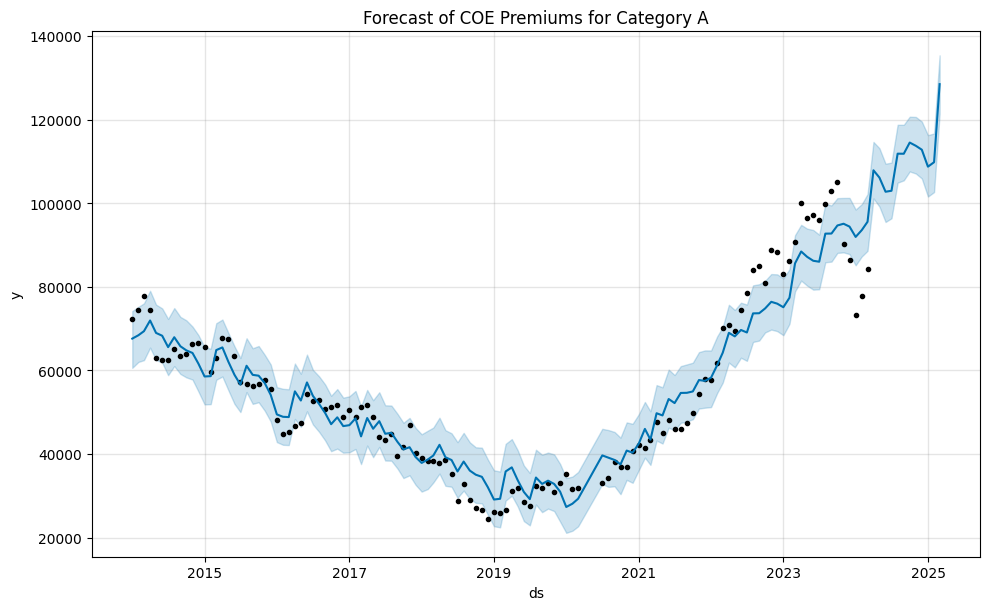

In [8]:
# Create future dataframe
future = model.make_future_dataframe(periods=12, freq='M')
future['bids_success'] = avg_bids_success  # Use historical average
future['bids_received'] = avg_bids_received  # Use historical average
future['deregistered_vehicles'] = avg_deregistered  # Use historical average
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecast of COE Premiums for Category A')
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]18:46:54 - cmdstanpy - INFO - Chain [1] start processing
18:46:54 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/15 [00:00<00:01,  9.22it/s]18:46:54 - cmdstanpy - INFO - Chain [1] start processing
18:46:54 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 2/15 [00:00<00:01,  8.64it/s]18:46:54 - cmdstanpy - INFO - Chain [1] start processing
18:46:54 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 3/15 [00:00<00:01,  9.13it/s]18:46:54 - cmdstanpy - INFO - Chain [1] start processing
18:46:55 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 4/15 [00:00<00:01,  9.07it/s]18:46:55 - cmdstanpy - INFO - Chain [1] start processing
18:46:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 5/15 [00:00<00:01,  8.49it/s]18:46:55 - cmdstanpy - INFO - Chain [1] start processing
18:46:55 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 6/15 [00:00<00:01,  8.82it/s]18:46:55

  horizon           mse         rmse          mae      mape     mdape  \
0 38 days  6.784722e+07  8236.942191  6632.961540  0.154100  0.134935   
1 39 days  6.894924e+07  8303.568206  6858.342108  0.161406  0.136900   
2 43 days  6.820014e+07  8258.337519  6788.575493  0.161180  0.136900   
3 49 days  6.483715e+07  8052.151956  6457.263327  0.147598  0.134935   
4 50 days  6.618321e+07  8135.306454  6709.614671  0.152918  0.134935   

      smape  coverage  
0  0.163041  0.235294  
1  0.170944  0.176471  
2  0.172153  0.176471  
3  0.160877  0.235294  
4  0.166545  0.176471  


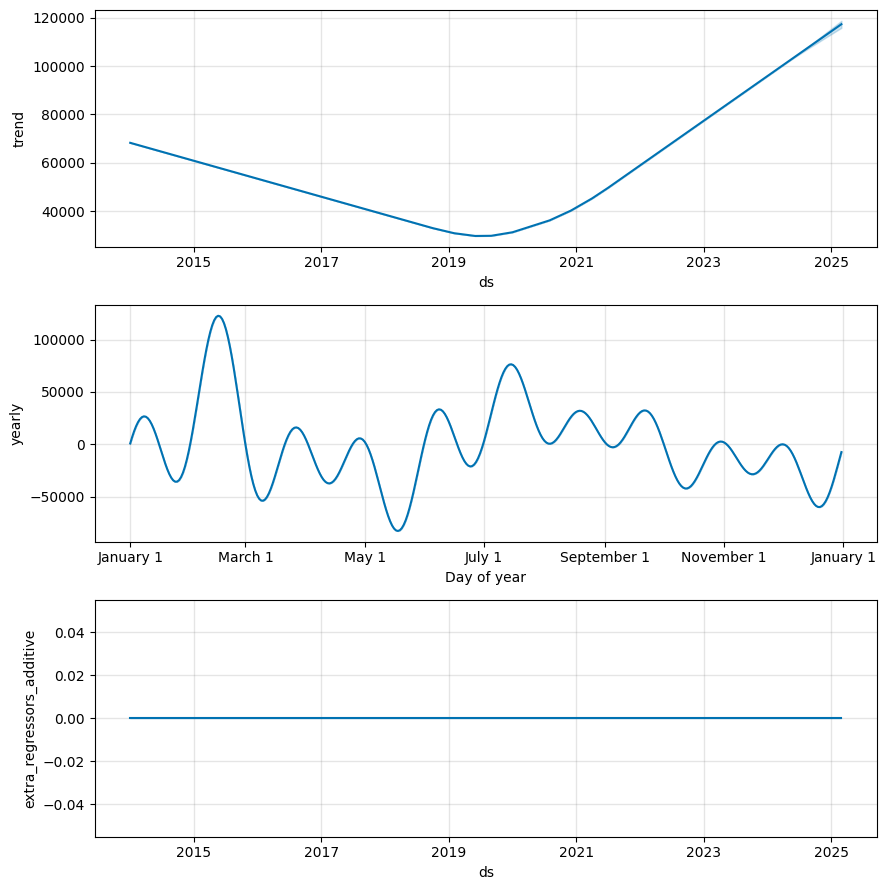

In [9]:
# Perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print(df_p.head())

# Plot performance metrics
fig = model.plot_components(forecast)

In [10]:
param_grid = {  
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0],
    'changepoint_prior_scale': [0.1, 0.5, 0.9]
}

# Assuming df_prophet is your pre-processed DataFrame ready for modeling
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use first 80% of the dataset for training
train_size = int(0.8 * len(df_prophet))
train = df_prophet.iloc[:train_size]
test = df_prophet.iloc[train_size:]

for params in all_params:
    m = Prophet(**params)
    m.add_regressor('bids_success')
    m.add_regressor('bids_received')
    m.add_regressor('deregistered_vehicles')
    m.fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
best_params = all_params[np.argmin(rmses)]
print(best_params)

18:46:57 - cmdstanpy - INFO - Chain [1] start processing


18:46:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/11 [00:00<?, ?it/s]18:46:57 - cmdstanpy - INFO - Chain [1] start processing
18:46:57 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 1/11 [00:00<00:01,  8.46it/s]18:46:58 - cmdstanpy - INFO - Chain [1] start processing
18:46:58 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 2/11 [00:00<00:01,  8.73it/s]18:46:58 - cmdstanpy - INFO - Chain [1] start processing
18:46:58 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 3/11 [00:00<00:01,  7.82it/s]18:46:58 - cmdstanpy - INFO - Chain [1] start processing
18:46:58 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▋      | 4/11 [00:00<00:01,  6.65it/s]18:46:58 - cmdstanpy - INFO - Chain [1] start processing
18:46:58 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▌     | 5/11 [00:00<00:01,  5.78it/s]18:46:58 - cmdstanpy - INFO - Chain [1] start processing
18:46:58 - cmdstanpy - INFO - Chain [1] done processin

{'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'changepoint_prior_scale': 0.5}


18:55:09 - cmdstanpy - INFO - Chain [1] start processing


18:55:09 - cmdstanpy - INFO - Chain [1] done processing
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to

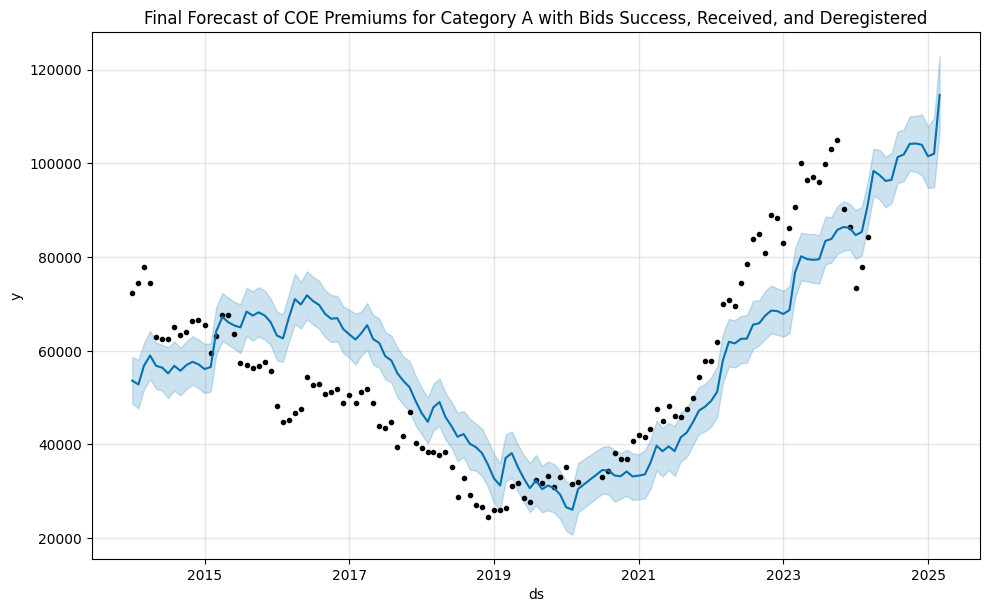

In [11]:
# Refit the model with the best parameters on the entire dataset
final_model = Prophet(**best_params)
final_model.add_regressor('bids_success')
final_model.add_regressor('bids_received')
final_model.add_regressor('deregistered_vehicles')
final_model.fit(df_prophet)

# Create future dataframe for final prediction
future = final_model.make_future_dataframe(periods=12, freq='M')
future['bids_success'] = avg_bids_success  # Use historical average
future['bids_received'] = avg_bids_received  # Use historical average
future['deregistered_vehicles'] = avg_deregistered  # Use historical average

# Predict the future with the final model
final_forecast = final_model.predict(future)

# Plot the final forecast
fig = final_model.plot(final_forecast)
plt.title('Final Forecast of COE Premiums for Category A with Bids Success, Received, and Deregistered')
plt.show()

# Plot the forecast components
# fig = final_model.plot_components(final_forecast)
# plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]18:55:09 - cmdstanpy - INFO - Chain [1] start processing
18:55:18 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/15 [00:08<02:02,  8.78s/it]18:55:18 - cmdstanpy - INFO - Chain [1] start processing
18:55:28 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 2/15 [00:18<02:05,  9.62s/it]18:55:28 - cmdstanpy - INFO - Chain [1] start processing
18:55:39 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 3/15 [00:29<02:02, 10.24s/it]18:55:39 - cmdstanpy - INFO - Chain [1] start processing
18:55:39 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 4/15 [00:30<01:09,  6.28s/it]18:55:39 - cmdstanpy - INFO - Chain [1] start processing
18:55:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 5/15 [00:30<00:40,  4.10s/it]18:55:39 - cmdstanpy - INFO - Chain [1] start processing
18:55:39 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 6/15 [00:30<00:25,  2.81s/it]18:55:39

  horizon           mse         rmse          mae      mape     mdape  \
0 38 days  1.719640e+07  4146.854821  3310.897455  0.080028  0.074125   
1 39 days  1.930682e+07  4393.953017  3628.192567  0.090264  0.083411   
2 43 days  1.909317e+07  4369.573410  3555.555753  0.088630  0.083411   
3 49 days  1.847457e+07  4298.205446  3439.239603  0.083352  0.074125   
4 50 days  1.790393e+07  4231.303512  3347.427380  0.079065  0.051830   

      smape  coverage  
0  0.081757  0.411765  
1  0.093161  0.352941  
2  0.091592  0.352941  
3  0.086758  0.411765  
4  0.082064  0.470588  


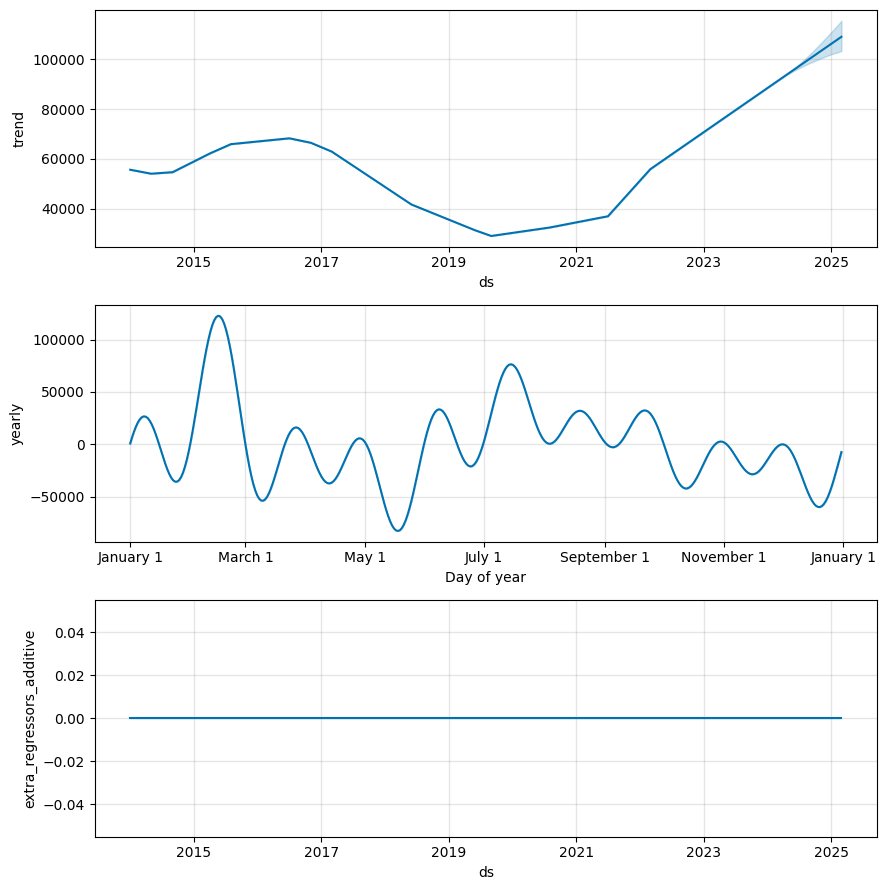

In [12]:
# Perform cross-validation
df_cv = cross_validation(final_model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print(df_p.head())

# Plot performance metrics
fig = model.plot_components(final_forecast)

In [13]:
print(df_prophet)

            ds        y  bids_success  bids_received  deregistered_vehicles
0   2014-01-01  72329.5         362.5          673.5                   1011
1   2014-02-01  74382.5         357.0          709.5                   1104
2   2014-03-01  77800.5         358.0          596.0                   1330
3   2014-04-01  74367.5         358.5          525.0                   1347
4   2014-05-01  62845.5         509.0          836.5                   1271
..         ...      ...           ...            ...                    ...
115 2023-11-01  90345.0         920.0         1228.0                   1654
116 2023-12-01  86510.0         919.0         1199.5                   1939
117 2024-01-01  73299.5         920.5         1532.0                   1918
118 2024-02-01  77900.5         923.0         1920.0                   1672
119 2024-03-01  84244.5         929.0         1894.0                   2420

[120 rows x 5 columns]


In [14]:
# Filter data for Category B
category_b_data = data[data['vehicle_class'] == 'Category B']
print(category_b_data)
# Aggregate data to monthly level
monthly_data = category_b_data.groupby(category_b_data['month'].dt.to_period('M')).agg({
    'premium': 'mean',
    'bids_success': 'mean',
    'bids_received': 'mean'
}).reset_index()
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

          month  bidding_no vehicle_class  quota  bids_success  bids_received  \
1    2010-01-01           1    Category B    687           679            883   
6    2010-01-01           2    Category B    717           717           1105   
11   2010-02-01           1    Category B    693           690            930   
16   2010-02-01           2    Category B    685           658            956   
21   2010-03-01           1    Category B    688           667           1087   
...         ...         ...           ...    ...           ...            ...   
1671 2024-03-01           1    Category B    708           704           1073   
1676 2024-03-01           2    Category B    656           615           1066   
1681 2024-04-01           1    Category B    653           645           1208   
1686 2024-04-01           2    Category B    690           690           1008   
1691 2024-05-01           1    Category B    666           638           1237   

      premium  
1       191

In [15]:
dereg_df = pd.DataFrame(dereg_data)
dereg_df['Date'] = pd.to_datetime(dereg_df['Date'], format='%Y-%b')
dereg_df = dereg_df.rename(columns={'Date': 'ds', 'Category_B_DeRegistered': 'deregistered_vehicles'})

In [16]:
# Merge the deregistration data with the aggregated monthly COE data
merged_data = pd.merge(monthly_data, dereg_df, left_on='month', right_on='ds', how='inner')

In [17]:
# Prepare the data for Prophet
df_prophet = merged_data[['month', 'premium', 'bids_success', 'bids_received', 'deregistered_vehicles']].rename(columns={'month': 'ds', 'premium': 'y'})
print(df_prophet)

            ds         y  bids_success  bids_received  deregistered_vehicles
0   2014-01-01   78850.0         382.5          546.5                    927
1   2014-02-01   76952.0         356.5          521.0                    926
2   2014-03-01   81805.0         344.5          511.5                   1308
3   2014-04-01   79757.0         356.0          504.5                   1068
4   2014-05-01   69052.5         474.5          747.0                   1101
..         ...       ...           ...            ...                    ...
115 2023-11-01  122668.5         634.5         1029.0                   1041
116 2023-12-01  120050.5         628.5          890.0                   1045
117 2024-01-01   98505.0         642.5         1079.0                   1236
118 2024-02-01   99669.0         619.0         1098.5                   1112
119 2024-03-01   96010.5         659.5         1069.5                   1246

[120 rows x 5 columns]


In [18]:
# Calculate historical averages for future values
avg_bids_success = df_prophet['bids_success'].mean()
avg_bids_received = df_prophet['bids_received'].mean()
avg_deregistered = df_prophet['deregistered_vehicles'].mean()

In [19]:
# Initialize the model
model = Prophet()

# Add additional regressors
model.add_regressor('bids_success')
model.add_regressor('bids_received')
model.add_regressor('deregistered_vehicles')

# Fit the model
model.fit(df_prophet)

18:55:43 - cmdstanpy - INFO - Chain [1] start processing
18:55:43 - cmdstanpy - INFO - Chain [1] done processing


/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


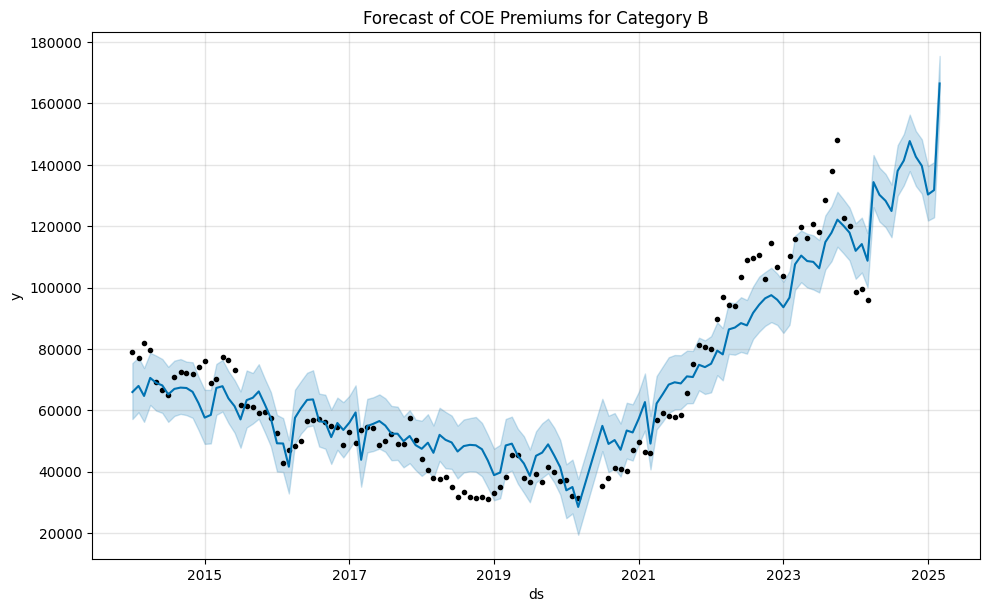

In [20]:
# Create future dataframe
future = model.make_future_dataframe(periods=12, freq='M')
future['bids_success'] = avg_bids_success  # Use historical average
future['bids_received'] = avg_bids_received  # Use historical average
future['deregistered_vehicles'] = avg_deregistered  # Use historical average
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecast of COE Premiums for Category B')
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]18:55:43 - cmdstanpy - INFO - Chain [1] start processing
18:55:43 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/15 [00:00<00:01,  7.42it/s]18:55:43 - cmdstanpy - INFO - Chain [1] start processing
18:55:43 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 2/15 [00:00<00:01,  7.14it/s]18:55:43 - cmdstanpy - INFO - Chain [1] start processing
18:55:43 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 3/15 [00:00<00:01,  7.67it/s]18:55:43 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 4/15 [00:00<00:01,  8.37it/s]18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 5/15 [00:00<00:01,  8.43it/s]18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 6/15 [00:00<00:01,  8.57it/s]18:55:44

  horizon           mse          rmse           mae      mape     mdape  \
0 38 days  1.653261e+08  12857.921077  10846.925034  0.210859  0.202056   
1 39 days  1.727287e+08  13142.628617  11466.168977  0.224604  0.206573   
2 43 days  1.661357e+08  12889.362212  11072.922495  0.213634  0.202056   
3 49 days  1.675770e+08  12945.153552  11177.906331  0.213804  0.202056   
4 50 days  1.829776e+08  13526.920127  11745.757788  0.220843  0.206573   

      smape  coverage  
0  0.230858  0.294118  
1  0.246665  0.235294  
2  0.238688  0.294118  
3  0.241057  0.235294  
4  0.250279  0.235294  


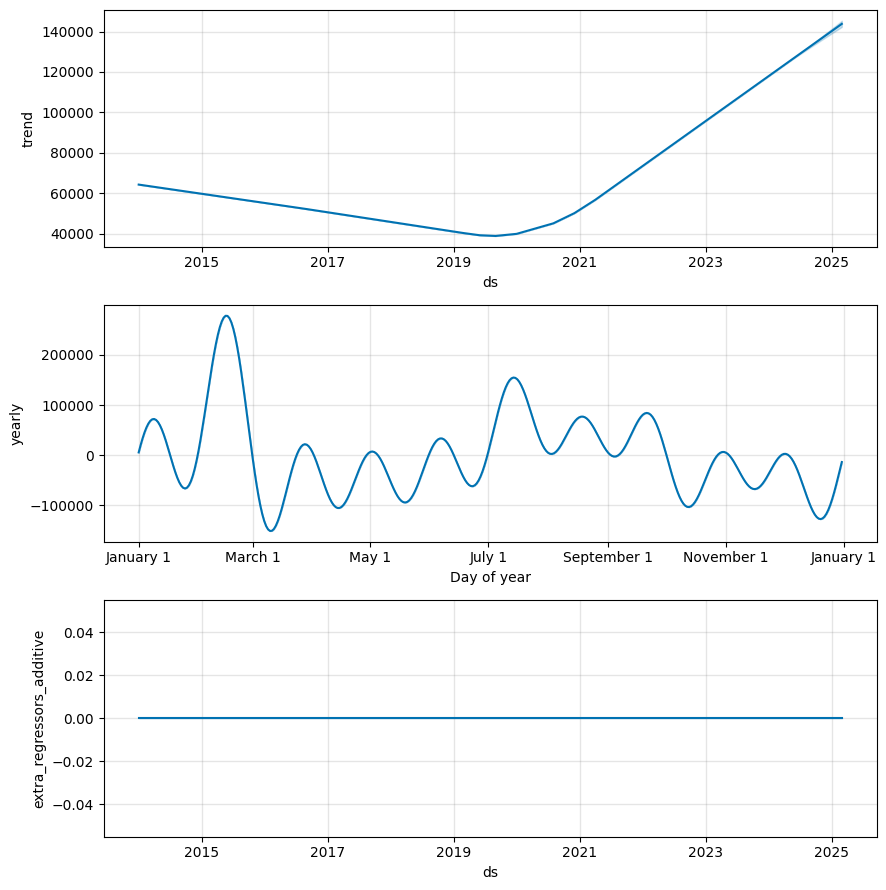

In [21]:
# Perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print(df_p.head())

# Plot performance metrics
fig = model.plot_components(forecast)

In [22]:
param_grid = {  
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0],
    'changepoint_prior_scale': [0.1, 0.5, 0.9]
}

# Assuming df_prophet is your pre-processed DataFrame ready for modeling
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use first 80% of the dataset for training
train_size = int(0.8 * len(df_prophet))
train = df_prophet.iloc[:train_size]
test = df_prophet.iloc[train_size:]

for params in all_params:
    m = Prophet(**params)
    m.add_regressor('bids_success')
    m.add_regressor('bids_received')
    m.add_regressor('deregistered_vehicles')
    m.fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
best_params = all_params[np.argmin(rmses)]
print(best_params)

18:55:46 - cmdstanpy - INFO - Chain [1] start processing
18:55:46 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/11 [00:00<?, ?it/s]18:55:46 - cmdstanpy - INFO - Chain [1] start processing
18:55:46 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 1/11 [00:00<00:01,  8.26it/s]18:55:46 - cmdstanpy - INFO - Chain [1] start processing
18:55:46 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 2/11 [00:00<00:01,  7.53it/s]18:55:46 - cmdstanpy - INFO - Chain [1] start processing
18:55:46 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 3/11 [00:00<00:01,  7.50it/s]18:55:46 - cmdstanpy - INFO - Chain [1] start processing
18:55:46 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▋      | 4/11 [00:00<00:00,  7.61it/s]18:55:46 - cmdstanpy - INFO - Chain [1] start processing
18:55:47 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▌     | 5/11 [00:00<00:00,  8.31it/s]18:55:47 - cmdstanpy - INFO - Chain [1] start processi

{'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.9}


19:05:59 - cmdstanpy - INFO - Chain [1] start processing


19:05:59 - cmdstanpy - INFO - Chain [1] done processing
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to

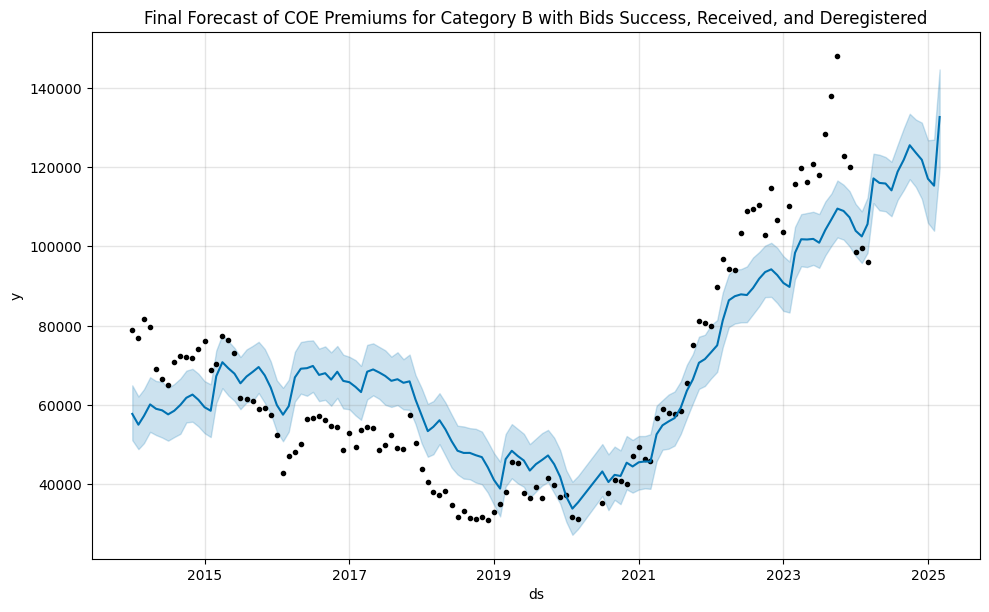

In [23]:
# Refit the model with the best parameters on the entire dataset
final_model = Prophet(**best_params)
final_model.add_regressor('bids_success')
final_model.add_regressor('bids_received')
final_model.add_regressor('deregistered_vehicles')
final_model.fit(df_prophet)

# Create future dataframe for final prediction
future = final_model.make_future_dataframe(periods=12, freq='M')
future['bids_success'] = avg_bids_success  # Use historical average
future['bids_received'] = avg_bids_received  # Use historical average
future['deregistered_vehicles'] = avg_deregistered  # Use historical average

# Predict the future with the final model
final_forecast = final_model.predict(future)

# Plot the final forecast
fig = final_model.plot(final_forecast)
plt.title('Final Forecast of COE Premiums for Category B with Bids Success, Received, and Deregistered')
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]19:06:00 - cmdstanpy - INFO - Chain [1] start processing
19:06:08 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/15 [00:08<02:02,  8.78s/it]19:06:08 - cmdstanpy - INFO - Chain [1] start processing
19:06:19 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 2/15 [00:18<02:04,  9.61s/it]19:06:19 - cmdstanpy - INFO - Chain [1] start processing
19:06:29 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 3/15 [00:29<02:02, 10.20s/it]19:06:29 - cmdstanpy - INFO - Chain [1] start processing
19:06:41 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 4/15 [00:41<01:58, 10.78s/it]19:06:41 - cmdstanpy - INFO - Chain [1] start processing
19:06:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 5/15 [00:41<01:10,  7.00s/it]19:06:41 - cmdstanpy - INFO - Chain [1] start processing
19:06:42 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 6/15 [00:42<00:42,  4.70s/it]19:06:42

  horizon           mse         rmse          mae      mape     mdape  \
0 38 days  5.349275e+07  7313.873699  5819.982731  0.102346  0.077752   
1 39 days  6.525276e+07  8077.917770  6457.084082  0.116795  0.104237   
2 43 days  6.434352e+07  8021.441494  6334.868027  0.113281  0.070442   
3 49 days  6.451327e+07  8032.015431  6396.000212  0.114451  0.070442   
4 50 days  6.616922e+07  8134.446213  6459.501007  0.111837  0.070442   

      smape  coverage  
0  0.107333  0.352941  
1  0.125621  0.352941  
2  0.122425  0.411765  
3  0.123685  0.411765  
4  0.120263  0.411765  


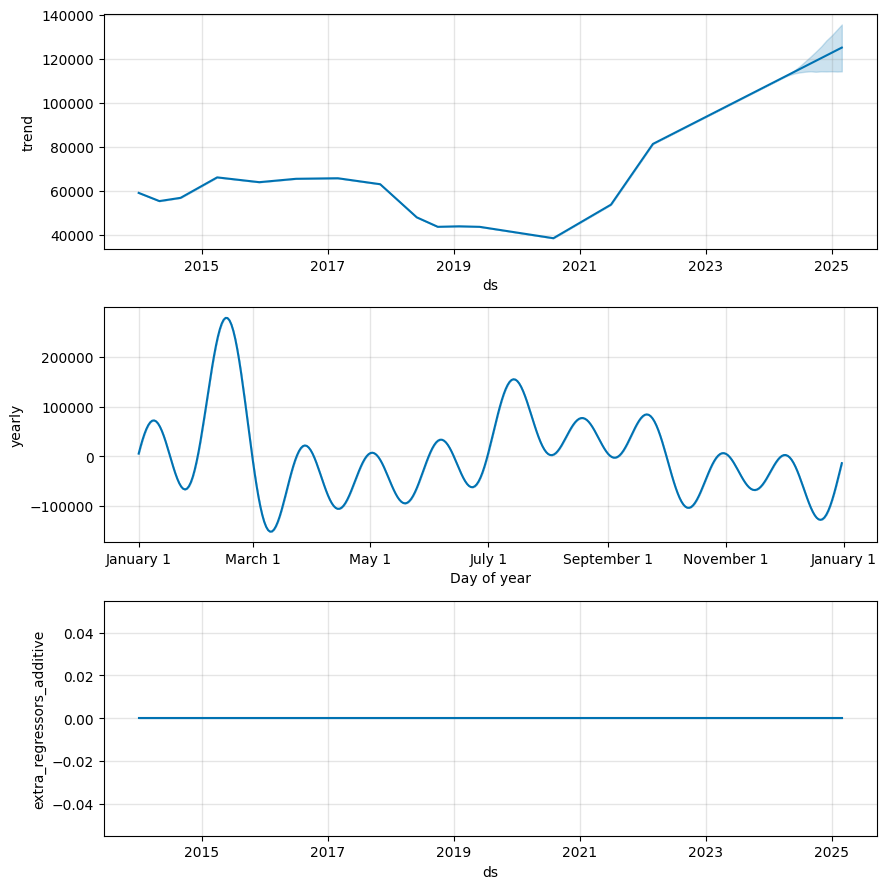

In [24]:
# Perform cross-validation
df_cv = cross_validation(final_model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print(df_p.head())

# Plot performance metrics
fig = model.plot_components(final_forecast)

In [25]:
# Cat C

In [39]:
# Filter data for Category C
category_c_data = data[data['vehicle_class'] == 'Category C']
print(category_c_data)
# Aggregate data to monthly level
monthly_data = category_c_data.groupby(category_c_data['month'].dt.to_period('M')).agg({
    'premium': 'mean',
    'bids_success': 'mean',
    'bids_received': 'mean'
}).reset_index()
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

          month  bidding_no vehicle_class  quota  bids_success  bids_received  \
2    2010-01-01           1    Category C    173           173            265   
7    2010-01-01           2    Category C    181           173            280   
12   2010-02-01           1    Category C    165           162            250   
17   2010-02-01           2    Category C    173           170            285   
22   2010-03-01           1    Category C    168           164            257   
...         ...         ...           ...    ...           ...            ...   
1672 2024-03-01           1    Category C    200           198            303   
1677 2024-03-01           2    Category C    202           202            313   
1682 2024-04-01           1    Category C    197           196            365   
1687 2024-04-01           2    Category C    195           193            332   
1692 2024-05-01           1    Category C    206           181            350   

      premium  
2       190

In [27]:
dereg_df = pd.DataFrame(dereg_data)
dereg_df['Date'] = pd.to_datetime(dereg_df['Date'], format='%Y-%b')
dereg_df = dereg_df.rename(columns={'Date': 'ds', 'Category_C_DeRegistered': 'deregistered_vehicles'})

In [28]:
# Merge the deregistration data with the aggregated monthly COE data
merged_data = pd.merge(monthly_data, dereg_df, left_on='month', right_on='ds', how='inner')

In [29]:
# Prepare the data for Prophet
df_prophet = merged_data[['month', 'premium', 'bids_success', 'bids_received', 'deregistered_vehicles']].rename(columns={'month': 'ds', 'premium': 'y'})
print(df_prophet)

            ds        y  bids_success  bids_received  deregistered_vehicles
0   2014-01-01  49445.0         250.5          346.5                    711
1   2014-02-01  51946.0         268.5          378.0                    832
2   2014-03-01  55096.5         259.0          397.5                   1700
3   2014-04-01  41196.5         263.5          347.5                   1267
4   2014-05-01  38595.0         387.5          712.0                    590
..         ...      ...           ...            ...                    ...
115 2023-11-01  75945.0         186.0          324.5                    372
116 2023-12-01  70212.0         188.5          352.5                    414
117 2024-01-01  67800.0         189.5          367.0                    502
118 2024-02-01  72501.0         191.5          370.0                    556
119 2024-03-01  72855.5         200.0          308.0                    949

[120 rows x 5 columns]


In [30]:
# Calculate historical averages for future values
avg_bids_success = df_prophet['bids_success'].mean()
avg_bids_received = df_prophet['bids_received'].mean()
avg_deregistered = df_prophet['deregistered_vehicles'].mean()

In [31]:
# Initialize the model
model = Prophet()

# Add additional regressors
model.add_regressor('bids_success')
model.add_regressor('bids_received')
model.add_regressor('deregistered_vehicles')

# Fit the model
model.fit(df_prophet)

19:06:44 - cmdstanpy - INFO - Chain [1] start processing
19:06:44 - cmdstanpy - INFO - Chain [1] done processing


/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


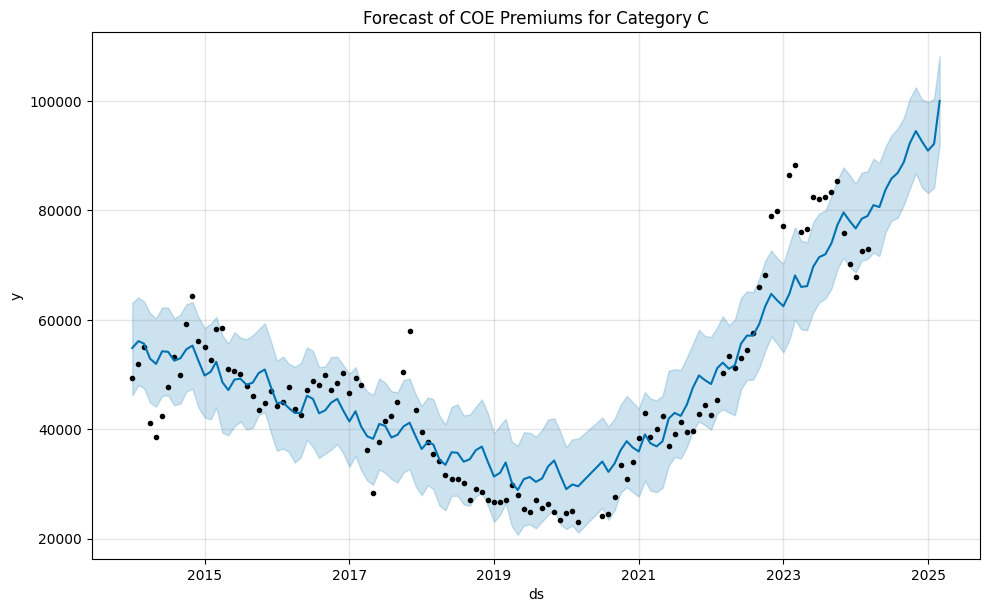

In [32]:
# Create future dataframe
future = model.make_future_dataframe(periods=12, freq='M')
future['bids_success'] = avg_bids_success  # Use historical average
future['bids_received'] = avg_bids_received  # Use historical average
future['deregistered_vehicles'] = avg_deregistered  # Use historical average
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecast of COE Premiums for Category C')
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/15 [00:00<00:01,  9.04it/s]19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 2/15 [00:00<00:01,  8.55it/s]19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] done processing
19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 4/15 [00:00<00:01,  9.04it/s]19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 5/15 [00:00<00:01,  8.65it/s]19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 6/15 [00:00<00:01,  7.44it/s]19:06:45 - cmdstanpy - INFO - Chain [1] start processi

  horizon           mse          rmse           mae      mape     mdape  \
0 38 days  2.900122e+08  17029.744670  12815.997313  0.342950  0.161264   
1 39 days  2.919589e+08  17086.805649  12964.637564  0.353205  0.243237   
2 43 days  2.920855e+08  17090.508971  12978.290486  0.356613  0.243237   
3 49 days  2.829917e+08  16822.355677  12555.488848  0.341134  0.231595   
4 50 days  3.095640e+08  17594.431486  13554.631963  0.361913  0.243237   

      smape  coverage  
0  0.364618  0.352941  
1  0.377196  0.352941  
2  0.380114  0.352941  
3  0.372191  0.352941  
4  0.402621  0.294118  


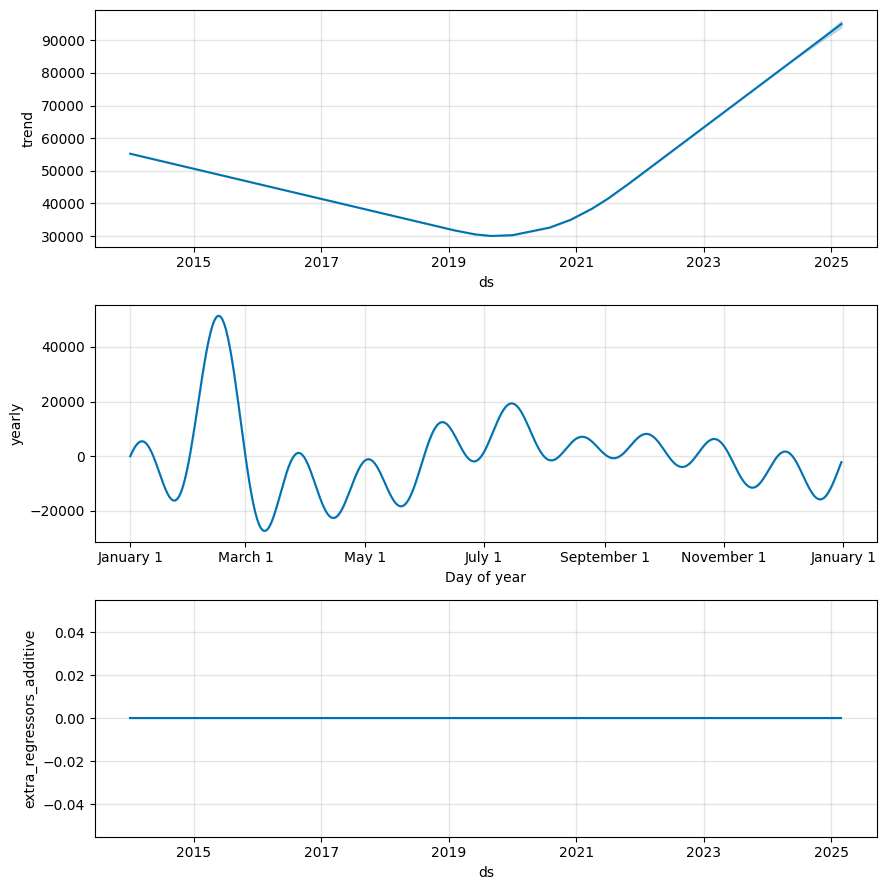

In [33]:
# Perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print(df_p.head())

# Plot performance metrics
fig = model.plot_components(forecast)

In [34]:
param_grid = {  
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0],
    'changepoint_prior_scale': [0.1, 0.5, 0.9]
}

# Assuming df_prophet is your pre-processed DataFrame ready for modeling
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use first 80% of the dataset for training
train_size = int(0.8 * len(df_prophet))
train = df_prophet.iloc[:train_size]
test = df_prophet.iloc[train_size:]

for params in all_params:
    m = Prophet(**params)
    m.add_regressor('bids_success')
    m.add_regressor('bids_received')
    m.add_regressor('deregistered_vehicles')
    m.fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
best_params = all_params[np.argmin(rmses)]
print(best_params)

19:06:47 - cmdstanpy - INFO - Chain [1] start processing
19:06:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/11 [00:00<?, ?it/s]19:06:48 - cmdstanpy - INFO - Chain [1] start processing
19:06:48 - cmdstanpy - INFO - Chain [1] done processing
19:06:48 - cmdstanpy - INFO - Chain [1] start processing
19:06:48 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 2/11 [00:00<00:00,  9.20it/s]19:06:48 - cmdstanpy - INFO - Chain [1] start processing
19:06:48 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 3/11 [00:00<00:00,  8.74it/s]19:06:48 - cmdstanpy - INFO - Chain [1] start processing
19:06:48 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▋      | 4/11 [00:00<00:00,  8.32it/s]19:06:48 - cmdstanpy - INFO - Chain [1] start processing
19:06:48 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▌     | 5/11 [00:00<00:00,  7.88it/s]19:06:48 - cmdstanpy - INFO - Chain [1] start processing
19:06:48 - cmdstanpy - INFO - Chain [1] don

{'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'changepoint_prior_scale': 0.9}


19:13:37 - cmdstanpy - INFO - Chain [1] start processing
19:13:38 - cmdstanpy - INFO - Chain [1] done processing
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call

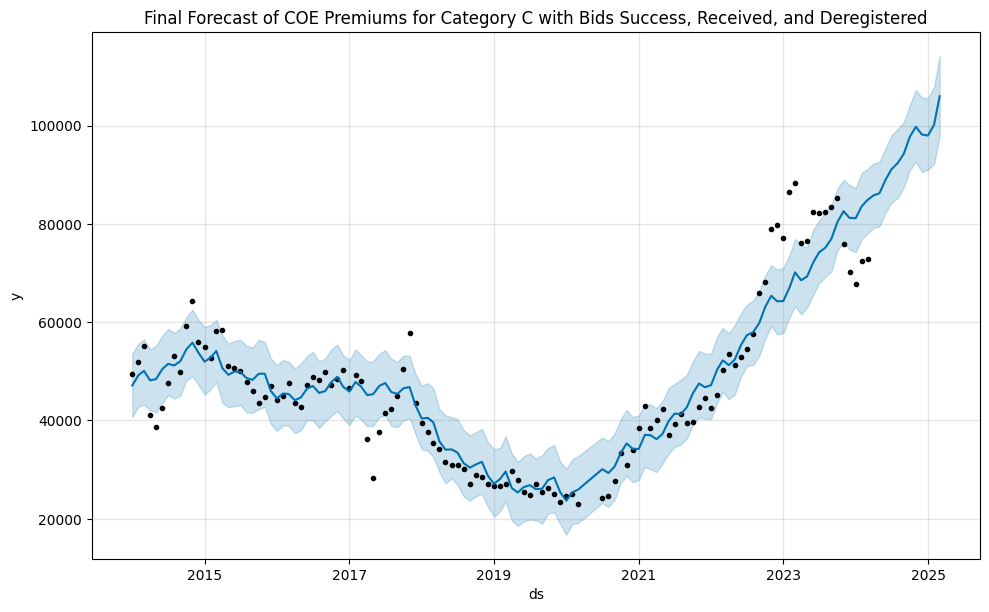

In [35]:
# Refit the model with the best parameters on the entire dataset
final_model = Prophet(**best_params)
final_model.add_regressor('bids_success')
final_model.add_regressor('bids_received')
final_model.add_regressor('deregistered_vehicles')
final_model.fit(df_prophet)

# Create future dataframe for final prediction
future = final_model.make_future_dataframe(periods=12, freq='M')
future['bids_success'] = avg_bids_success  # Use historical average
future['bids_received'] = avg_bids_received  # Use historical average
future['deregistered_vehicles'] = avg_deregistered  # Use historical average

# Predict the future with the final model
final_forecast = final_model.predict(future)

# Plot the final forecast
fig = final_model.plot(final_forecast)
plt.title('Final Forecast of COE Premiums for Category C with Bids Success, Received, and Deregistered')
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]19:13:38 - cmdstanpy - INFO - Chain [1] start processing
19:13:46 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/15 [00:08<02:01,  8.66s/it]19:13:46 - cmdstanpy - INFO - Chain [1] start processing
19:13:57 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 2/15 [00:18<02:04,  9.60s/it]19:13:57 - cmdstanpy - INFO - Chain [1] start processing
19:13:57 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 3/15 [00:19<01:04,  5.34s/it]19:13:57 - cmdstanpy - INFO - Chain [1] start processing
19:13:57 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 4/15 [00:19<00:36,  3.33s/it]19:13:57 - cmdstanpy - INFO - Chain [1] start processing
19:13:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 5/15 [00:19<00:22,  2.23s/it]19:13:57 - cmdstanpy - INFO - Chain [1] start processing
19:13:58 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 6/15 [00:20<00:14,  1.59s/it]19:13:58

  horizon           mse         rmse          mae      mape     mdape  \
0 38 days  5.542212e+07  7444.603385  6439.863297  0.167519  0.145590   
1 39 days  6.219946e+07  7886.663386  6875.520704  0.186901  0.160008   
2 43 days  6.316035e+07  7947.348716  6990.131391  0.193532  0.166944   
3 49 days  6.359751e+07  7974.804988  7060.458295  0.195490  0.166944   
4 50 days  6.083094e+07  7799.418890  6921.102527  0.185697  0.166944   

      smape  coverage  
0  0.188633  0.235294  
1  0.214045  0.235294  
2  0.219258  0.235294  
3  0.221878  0.176471  
4  0.208454  0.176471  


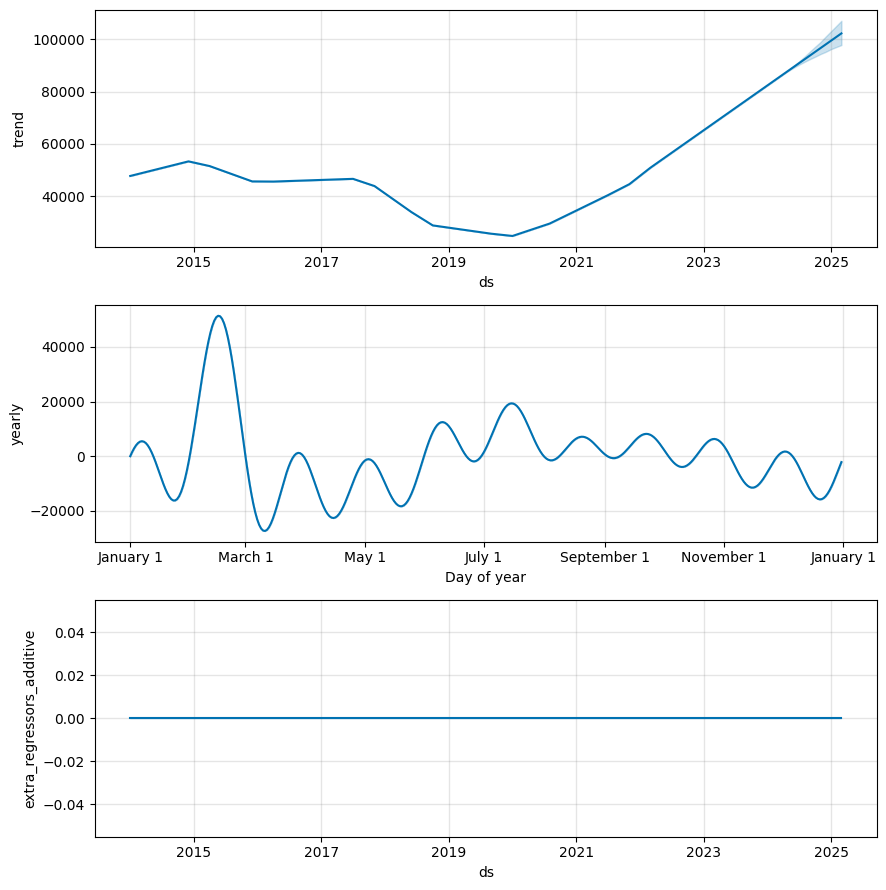

In [36]:
# Perform cross-validation
df_cv = cross_validation(final_model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print(df_p.head())

# Plot performance metrics
fig = model.plot_components(final_forecast)

In [37]:
# Category D

In [40]:
# Filter data for Category D
category_d_data = data[data['vehicle_class'] == 'Category D']
print(category_d_data)
# Aggregate data to monthly level
monthly_data = category_d_data.groupby(category_d_data['month'].dt.to_period('M')).agg({
    'premium': 'mean',
    'bids_success': 'mean',
    'bids_received': 'mean'
}).reset_index()
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

          month  bidding_no vehicle_class  quota  bids_success  bids_received  \
3    2010-01-01           1    Category D    373           365            509   
8    2010-01-01           2    Category D    378           378            551   
13   2010-02-01           1    Category D    371           349            525   
18   2010-02-01           2    Category D    363           355            472   
23   2010-03-01           1    Category D    385           383            467   
...         ...         ...           ...    ...           ...            ...   
1673 2024-03-01           1    Category D    520           518            646   
1678 2024-03-01           2    Category D    521           516            629   
1683 2024-04-01           1    Category D    520           510            610   
1688 2024-04-01           2    Category D    522           514            625   
1693 2024-05-01           1    Category D    528           528            630   

      premium  
3         8

In [41]:
dereg_df = pd.DataFrame(dereg_data)
dereg_df['Date'] = pd.to_datetime(dereg_df['Date'], format='%Y-%b')
dereg_df = dereg_df.rename(columns={'Date': 'ds', 'Category_D_DeRegistered': 'deregistered_vehicles'})

In [42]:
# Merge the deregistration data with the aggregated monthly COE data
merged_data = pd.merge(monthly_data, dereg_df, left_on='month', right_on='ds', how='inner')

In [43]:
# Prepare the data for Prophet
df_prophet = merged_data[['month', 'premium', 'bids_success', 'bids_received', 'deregistered_vehicles']].rename(columns={'month': 'ds', 'premium': 'y'})
print(df_prophet)

            ds        y  bids_success  bids_received  deregistered_vehicles
0   2014-01-01   2346.5         495.0          669.0                    760
1   2014-02-01   3276.0         356.0          514.0                    668
2   2014-03-01   4145.0         347.5          466.0                    796
3   2014-04-01   4495.5         369.0          506.0                    742
4   2014-05-01   4002.0         328.0          468.5                    637
..         ...      ...           ...            ...                    ...
115 2023-11-01  10445.0         515.0          666.0                    745
116 2023-12-01   9430.0         536.0          688.5                    837
117 2024-01-01   9211.5         502.5          640.5                   1019
118 2024-02-01   9100.5         538.0          703.0                    963
119 2024-03-01   9544.5         517.0          637.5                    694

[120 rows x 5 columns]


In [44]:
# Calculate historical averages for future values
avg_bids_success = df_prophet['bids_success'].mean()
avg_bids_received = df_prophet['bids_received'].mean()
avg_deregistered = df_prophet['deregistered_vehicles'].mean()

In [45]:
# Initialize the model
model = Prophet()

# Add additional regressors
model.add_regressor('bids_success')
model.add_regressor('bids_received')
model.add_regressor('deregistered_vehicles')

# Fit the model
model.fit(df_prophet)

19:33:21 - cmdstanpy - INFO - Chain [1] start processing
19:33:21 - cmdstanpy - INFO - Chain [1] done processing


/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


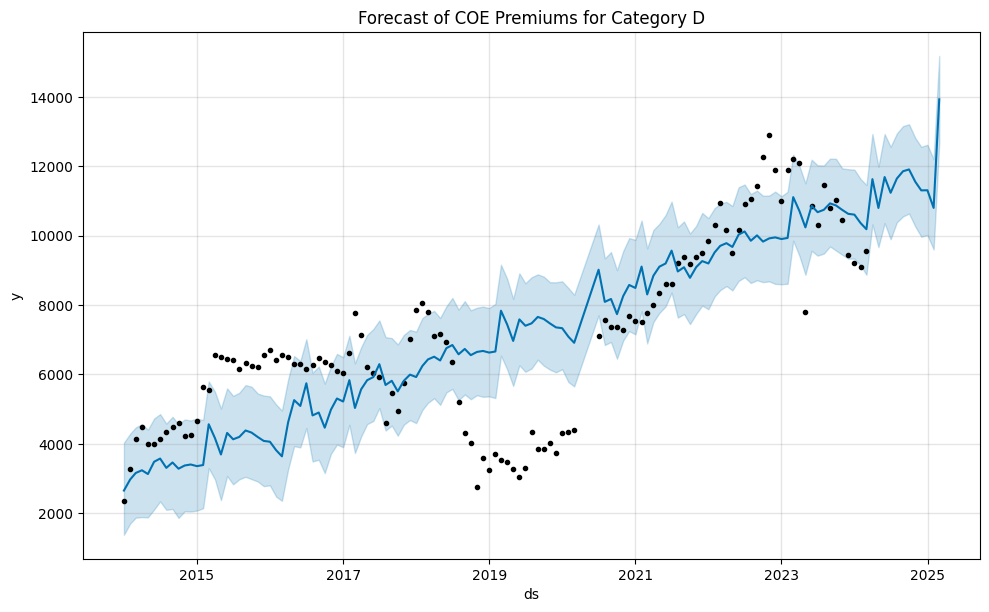

In [51]:
# Create future dataframe
future = model.make_future_dataframe(periods=12, freq='M')
future['bids_success'] = avg_bids_success  # Use historical average
future['bids_received'] = avg_bids_received  # Use historical average
future['deregistered_vehicles'] = avg_deregistered  # Use historical average
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecast of COE Premiums for Category D')
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]19:33:21 - cmdstanpy - INFO - Chain [1] start processing
19:33:21 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/15 [00:00<00:01,  8.69it/s]19:33:21 - cmdstanpy - INFO - Chain [1] start processing
19:33:21 - cmdstanpy - INFO - Chain [1] done processing
19:33:21 - cmdstanpy - INFO - Chain [1] start processing
19:33:22 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 3/15 [00:00<00:01,  8.41it/s]19:33:22 - cmdstanpy - INFO - Chain [1] start processing
19:33:22 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 4/15 [00:00<00:01,  7.25it/s]19:33:22 - cmdstanpy - INFO - Chain [1] start processing
19:33:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 5/15 [00:00<00:01,  7.67it/s]19:33:22 - cmdstanpy - INFO - Chain [1] start processing
19:33:22 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 6/15 [00:00<00:01,  7.52it/s]19:33:22 - cmdstanpy - INFO - Chain [1] start processi

  horizon           mse         rmse          mae      mape     mdape  \
0 38 days  1.473194e+06  1213.752062   864.903242  0.156162  0.101313   
1 39 days  1.678896e+06  1295.722199   933.785964  0.182702  0.101313   
2 43 days  1.885430e+06  1373.109651  1022.765621  0.207476  0.111639   
3 49 days  1.872786e+06  1368.497800  1011.345816  0.201670  0.101313   
4 50 days  1.608149e+06  1268.128121   943.700172  0.168566  0.101313   

      smape  coverage  
0  0.139794  0.588235  
1  0.158254  0.588235  
2  0.177697  0.529412  
3  0.172719  0.529412  
4  0.151921  0.529412  


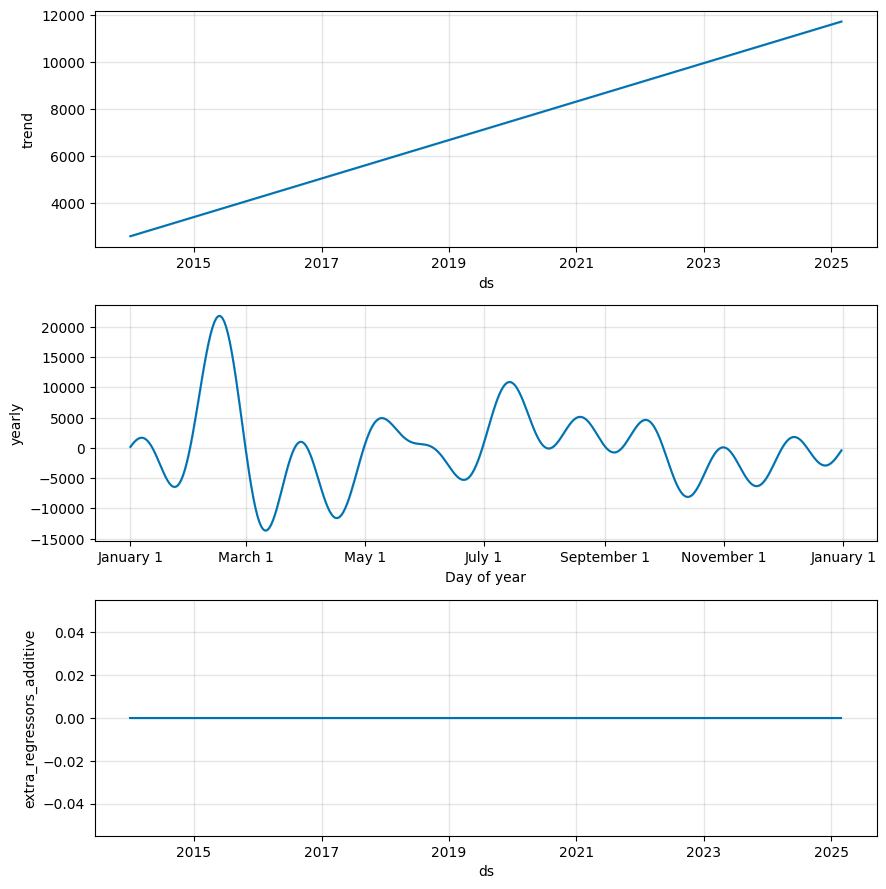

In [47]:
# Perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print(df_p.head())

# Plot performance metrics
fig = model.plot_components(forecast)

In [48]:
param_grid = {  
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0],
    'changepoint_prior_scale': [0.1, 0.5, 0.9]
}

# Assuming df_prophet is your pre-processed DataFrame ready for modeling
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use first 80% of the dataset for training
train_size = int(0.8 * len(df_prophet))
train = df_prophet.iloc[:train_size]
test = df_prophet.iloc[train_size:]

for params in all_params:
    m = Prophet(**params)
    m.add_regressor('bids_success')
    m.add_regressor('bids_received')
    m.add_regressor('deregistered_vehicles')
    m.fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
best_params = all_params[np.argmin(rmses)]
print(best_params)

19:33:24 - cmdstanpy - INFO - Chain [1] start processing
19:33:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/11 [00:00<?, ?it/s]19:33:24 - cmdstanpy - INFO - Chain [1] start processing
19:33:24 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 1/11 [00:00<00:01,  8.94it/s]19:33:24 - cmdstanpy - INFO - Chain [1] start processing
19:33:24 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 2/11 [00:00<00:01,  6.68it/s]19:33:24 - cmdstanpy - INFO - Chain [1] start processing
19:33:25 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 3/11 [00:00<00:01,  5.94it/s]19:33:25 - cmdstanpy - INFO - Chain [1] start processing
19:33:25 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▋      | 4/11 [00:00<00:01,  5.73it/s]19:33:25 - cmdstanpy - INFO - Chain [1] start processing
19:33:25 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▌     | 5/11 [00:00<00:01,  5.72it/s]19:33:25 - cmdstanpy - INFO - Chain [1] start processi

{'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'changepoint_prior_scale': 0.1}


19:43:55 - cmdstanpy - INFO - Chain [1] start processing
19:43:55 - cmdstanpy - INFO - Chain [1] done processing
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/anthony/miniforge3/envs/ce301/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call

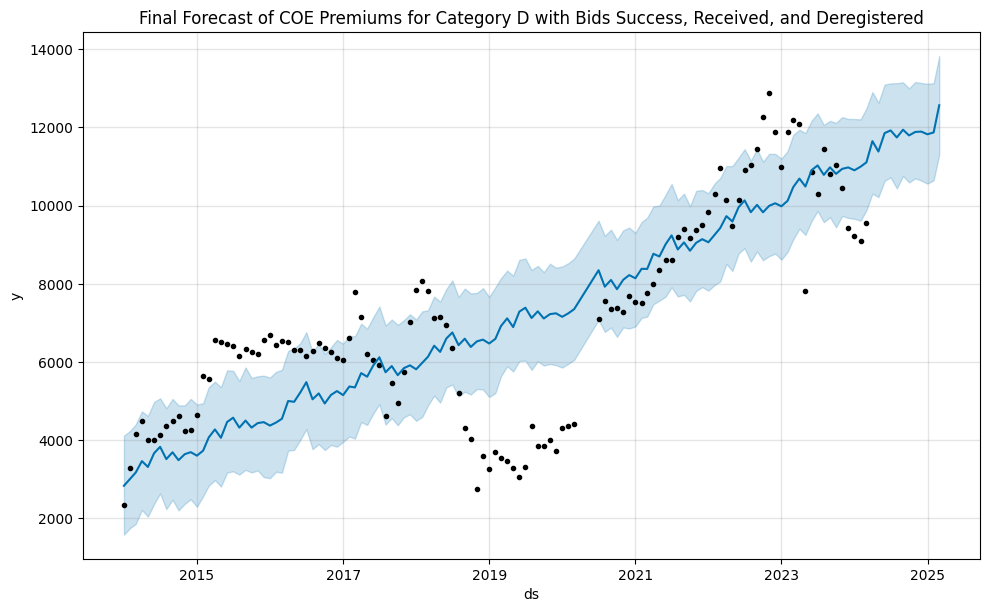

In [49]:
# Refit the model with the best parameters on the entire dataset
final_model = Prophet(**best_params)
final_model.add_regressor('bids_success')
final_model.add_regressor('bids_received')
final_model.add_regressor('deregistered_vehicles')
final_model.fit(df_prophet)

# Create future dataframe for final prediction
future = final_model.make_future_dataframe(periods=12, freq='M')
future['bids_success'] = avg_bids_success  # Use historical average
future['bids_received'] = avg_bids_received  # Use historical average
future['deregistered_vehicles'] = avg_deregistered  # Use historical average

# Predict the future with the final model
final_forecast = final_model.predict(future)

# Plot the final forecast
fig = final_model.plot(final_forecast)
plt.title('Final Forecast of COE Premiums for Category D with Bids Success, Received, and Deregistered')
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]19:43:55 - cmdstanpy - INFO - Chain [1] start processing
19:43:55 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/15 [00:00<00:02,  5.79it/s]19:43:55 - cmdstanpy - INFO - Chain [1] start processing
19:43:55 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 2/15 [00:00<00:02,  5.80it/s]19:43:55 - cmdstanpy - INFO - Chain [1] start processing
19:43:55 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 3/15 [00:00<00:02,  5.19it/s]19:43:56 - cmdstanpy - INFO - Chain [1] start processing
19:43:56 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 4/15 [00:00<00:02,  4.81it/s]19:43:56 - cmdstanpy - INFO - Chain [1] start processing
19:43:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 5/15 [00:00<00:01,  5.10it/s]19:43:56 - cmdstanpy - INFO - Chain [1] start processing
19:43:56 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 6/15 [00:01<00:01,  5.53it/s]19:43:56

  horizon            mse        rmse         mae      mape     mdape  \
0 38 days  707619.982483  841.201511  673.401892  0.120383  0.080408   
1 39 days  780726.570231  883.587330  705.361696  0.135440  0.080408   
2 43 days  777057.717842  881.508774  694.613803  0.134437  0.080408   
3 49 days  869374.878341  932.402745  732.491318  0.133805  0.080408   
4 50 days  802923.395674  896.059929  713.955473  0.112318  0.080408   

      smape  coverage  
0  0.111611  0.588235  
1  0.122993  0.588235  
2  0.122040  0.588235  
3  0.124193  0.588235  
4  0.111182  0.588235  


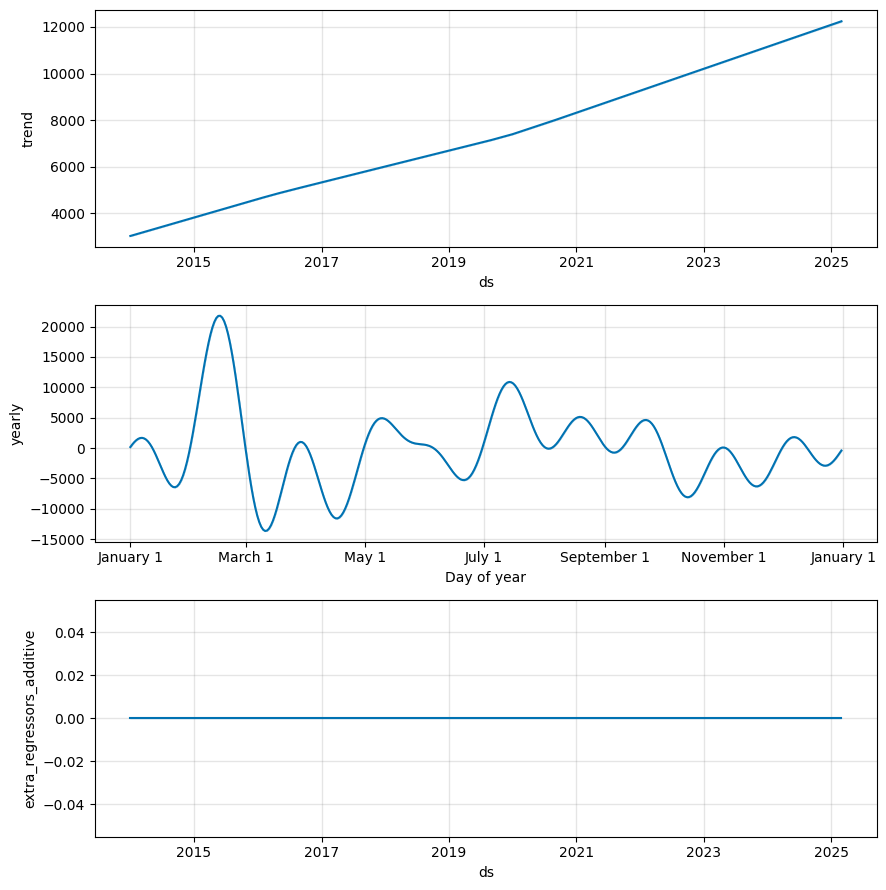

In [50]:
# Perform cross-validation
df_cv = cross_validation(final_model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print(df_p.head())

# Plot performance metrics
fig = model.plot_components(final_forecast)